# 팀프로젝트 Week1 ‒원티드 국민연금DB를 이용해서 유니콘 기업 발굴하기

데이터를 조인하면 회사의 국민연금고지금액, 매출액, 인원수를 월별로 볼 수 있습니다.       
유니콘기업으로 보이는 기업들을 나름의 방식으로 찾아주세요.        


**데이터정보**

- 회사수: 약5,000개
- 연도 : 2015 ~ 2019
- 월별데이터: 직원수, 국민연금보험료(인원 수에 대한 상한선_최대고지금액이 존재함)
- 년단위데이터: 매출액(천 원 단위)


**EDA 목표**

- 위 데이터들의 분포(직원수, 매출액, 보험료, +@)
- 몇몇 회사를 선택하여 데이터 흐름 살펴보기
- 데이터 사이의 관계에 대해 유의미한 결론을 찾아봅시다. (아이디어 수립==>EDA를 통해 관찰)



### 유니콘 기업 정의
**[유니콘 기업(Unicorn)은 기업 가치가 10억 달러(=1조 원) 이상이고 창업한 지 10년 이하인 비상장 스타트업 기업을 말한다.](https://ko.wikipedia.org/wiki/%EC%9C%A0%EB%8B%88%EC%BD%98_%EA%B8%B0%EC%97%85)**      


[캐치가 선정한 매출액 Top10 스타트업](https://m.catch.co.kr/Comp/CompThemeRank?TCode=163)
- 우아한 형제들
    - 매출액 : 1625억
    - 직원수 : 1050명(2020)
    
- 쏘카 
    - 매출액 : 1210억
    - 직원수 : 330명(2020)
    
- 네시삼십삼분
    - 매출액 : 722억 
    - 직원수 : 133명
    
- 딜리버리히어로코리아
    - 매출액 : 671억
    - 직원수 : 800명(2019)
    
- 리디 
    - 매출액 : 665억
    - 직원수 : 137명(2018)
    
- 야놀자
    - 매출액 : 545억
    - 직원수 : 1000명(2019)

- 블랭크코퍼레이션
    - 매출액 : 478억
    - 직원수 : 205명(2020)

- 레진엔터테인먼트
    - 매출액 : 448억
    - 직원수 : 143명(2019)

- 미미박스
    - 매출액 : 440억
    - 직원수 : 98명

- 뱅크웨어글로벌
    - 매출액 : 388억
    - 직원수 : 285명(2016)

  
#### 매출액 평균 : 719.2억 (최소 388억)       
#### 직원수 평균 : 418.1명 (최소 98명)     

### 기본 접근 방향
1. 매출액에 기반한 분석 ✔
    - 일정 금액 이상의 데이터만 남긴다 (매출액 최소 700억 이상)
    - 상승 추세만을 남기진 않지만, 시작값과 끝값의 차이가 음수라면 제거한다.
    

2. 직원수에 기반한 분석 ✔
    - 일정 직원 수 이상의 데이터만 남긴다. (최소 400명 이상)
    
    
3. ~국민연금 납부액 성장에 기반한 분석~
    - 직원수와 비례하기 때문에 연금납부액은 고려하지 않는다.

In [1]:
# 라이브러리 임포트
import os
import pandas as pd
import matplotlib.pyplot as plt
import sys

import warnings
warnings.filterwarnings('ignore')

print("파이썬 버전 :",sys.version)
print("판다스 버전 :",pd.__version__)

파이썬 버전 : 3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)]
판다스 버전 : 1.1.3


In [2]:
# 데이터 확인
path = "C:/Users/parkgun/Desktop/프리온보딩/팀프로젝트_1주차/data"
os.listdir(path)

# 데이터 불러오기
df = pd.read_csv(path+"/company_nps_data.csv", encoding="cp949")
display(df.head())

,회사ID,연매출액,년도,월,월별_연금보험료,월별_직원수
0,233757,41688077,2018,7,8912380,36
1,123464,1760695,2018,3,942380,5
2,342124,3221341,2018,7,781180,4
3,386420,4815584,2015,11,3795900,14
4,129243,9799736,2018,10,40724680,151


In [3]:
# 연도와 월을 묶어서 컬럼 형성
df['년월'] = pd.to_datetime(df['년도'].astype(str) + df['월'].astype(str), format='%Y%m').dt.strftime('%Y%m')

# 회사ID, 연도와 월을 제거해보자
df.drop(df[['년도','월']], axis=1, inplace=True)

# 시간순으로 나열해보자
df= df.sort_values(by='년월')

In [4]:
# 전체 파일 길이 
print("데이터 길이 :", len(df))

데이터 길이 : 99801


In [5]:
# 결측치 확인
df.isna().sum()

회사ID        0
연매출액        0
월별_연금보험료    0
월별_직원수      0
년월          0
dtype: int64

In [6]:
# 컬럼별 유니크 값 출력 ==> 특이점 없음
for col in df.columns:
    print(f"column : {col}")
    print(f"The number of unique : {df[col].nunique()}")
    print()

column : 회사ID
The number of unique : 5000

column : 연매출액
The number of unique : 10108

column : 월별_연금보험료
The number of unique : 50747

column : 월별_직원수
The number of unique : 1187

column : 년월
The number of unique : 50



In [7]:
# 연매출액 700억 이상 조건 적용
# 연 매출액 단위는 1000원 // 1조원 == 1000000000 // 1000억 == 100000000 // 100억원 == 10000000 // 

df_10_billion = df[df['연매출액']>=70000000] # 700억 ==> 매출액 Top10 스타트업 매출액 평균 : 719
display(df_10_billion.head())
print(df_10_billion.shape)

,회사ID,연매출액,월별_연금보험료,월별_직원수,년월
28116,126814,421492545,116361880,504,201511
48411,294387,132543154,130447840,640,201511
48494,128174,113326052,52671820,209,201511
79019,294337,102579741,244699780,1202,201511
30777,130577,119510605,27614100,105,201511


(3808, 5)


In [8]:
# 직원수 400명 이상 조건 적용

base_df = df_10_billion[df_10_billion['월별_직원수']>=400] # 400명 ==> 매출액 Top10 스타트업 직원수 평균 : 418
display(base_df.head())
print(base_df.shape)

,회사ID,연매출액,월별_연금보험료,월별_직원수,년월
28116,126814,421492545,116361880,504,201511
48411,294387,132543154,130447840,640,201511
79019,294337,102579741,244699780,1202,201511
95996,126521,567910907,525409000,1588,201511
29798,294367,601303965,218100420,852,201511


(1062, 5)


In [9]:
# 매출액이 700억 이상이며, 직원수가 400명 이상인 회사
print("회사 개수 :",base_df['회사ID'].nunique())

회사 개수 : 46


In [10]:
# 데이터가 일정 개수 이상 존재하는 회사만 남긴다.
new_df = base_df.groupby("회사ID").filter(lambda x : len(x) > 10) # 데이터가 10개 이상인 회사만 남긴다.
display(new_df.head())

,회사ID,연매출액,월별_연금보험료,월별_직원수,년월
28116,126814,421492545,116361880,504,201511
48411,294387,132543154,130447840,640,201511
79019,294337,102579741,244699780,1202,201511
95996,126521,567910907,525409000,1588,201511
29798,294367,601303965,218100420,852,201511


In [11]:
print("회사 리스트 :",new_df['회사ID'].unique())
print("회사 개수 :",new_df['회사ID'].nunique())

회사 리스트 : [126814 294387 294337 126521 294367 126538 126674 126516 126664 403351
 126983 227414 126606 126831 510329 227415 403359 403434 469458 419998
 126802 419945 419977 126772 440030 469473 469677 420046 420008 126641
     63     95 547586 630190]
회사 개수 : 34


In [12]:
# 매출액 및 직원수 시각화 함수

def visualization(df,x) :
    new_name = df[df['회사ID']==x]
    print(x,"회사 그래프입니다.")
    plt.figure(figsize=(20,10))
    plt.subplot(221)
    plt.plot(new_name['년월'],new_name['연매출액'])
    plt.title("매출액", fontsize=25)
    plt.xticks(rotation='vertical')
    plt.subplot(222)
    plt.plot(new_name['년월'],new_name['월별_직원수'])
    plt.title("직원수", fontsize=25)
    plt.xticks(rotation='vertical')
    plt.show()
    print()
    print()

In [13]:
# list_ID = new_df['회사ID'].unique()
# # 한번 직원수 기반 추출된 데이터로 매출액을 그려봅시다.

# for x in list_ID :
#     visualization(df,x)

294387 회사 그래프입니다.


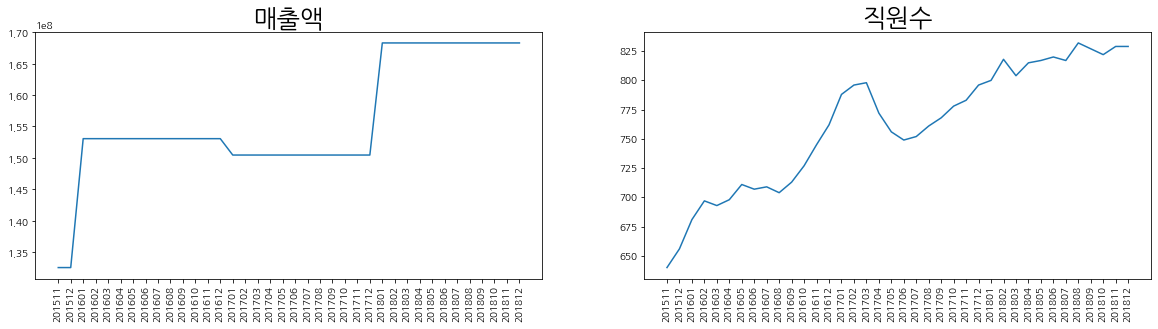



294337 회사 그래프입니다.


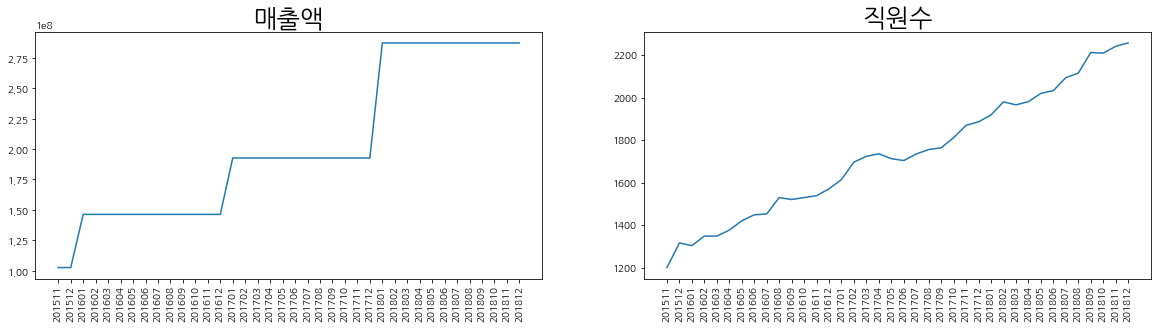



294367 회사 그래프입니다.


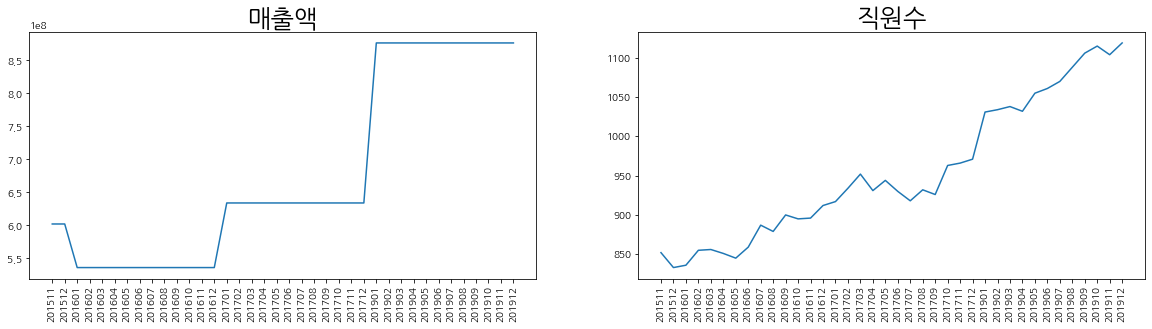



126664 회사 그래프입니다.


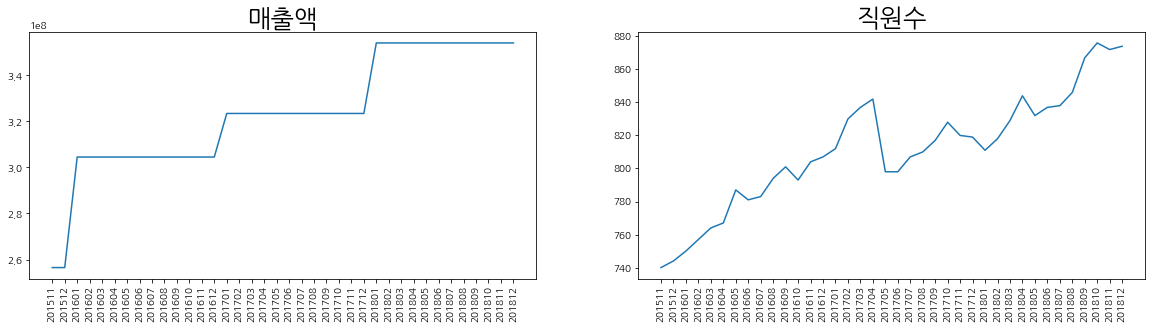



227414 회사 그래프입니다.


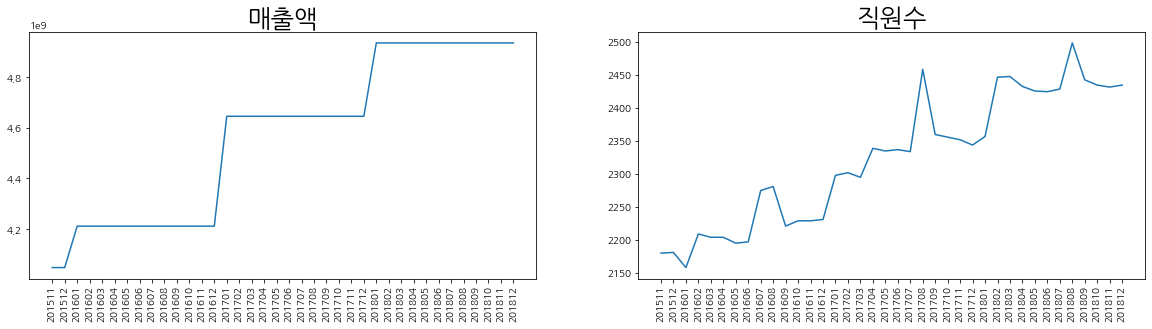



403359 회사 그래프입니다.


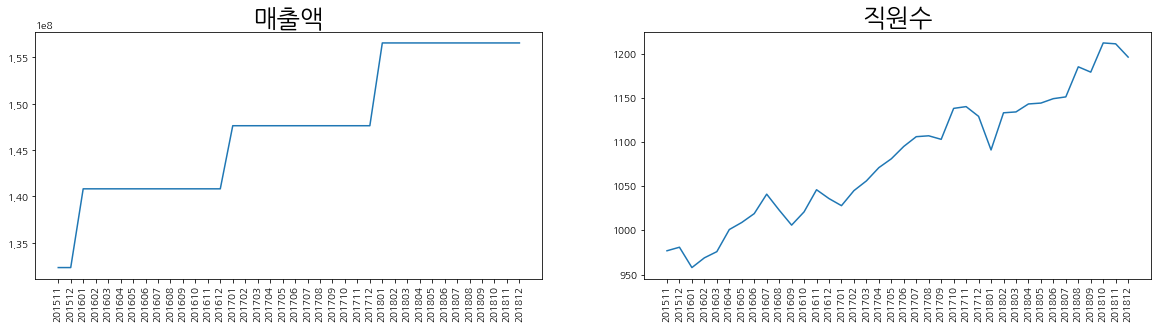



440030 회사 그래프입니다.


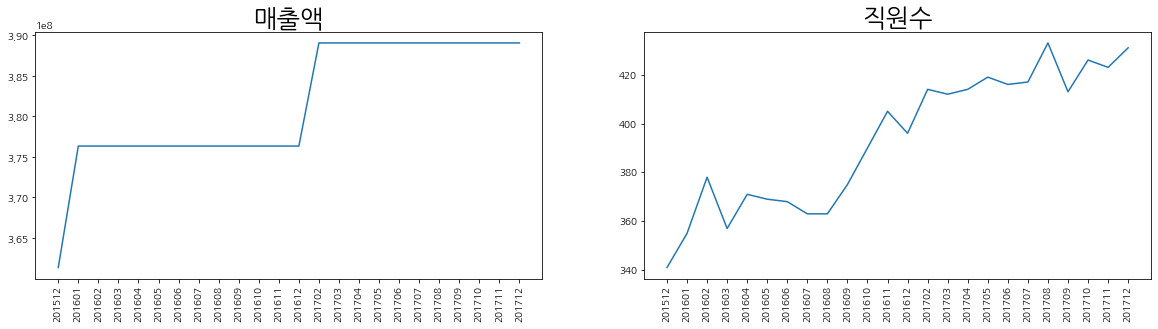



469677 회사 그래프입니다.


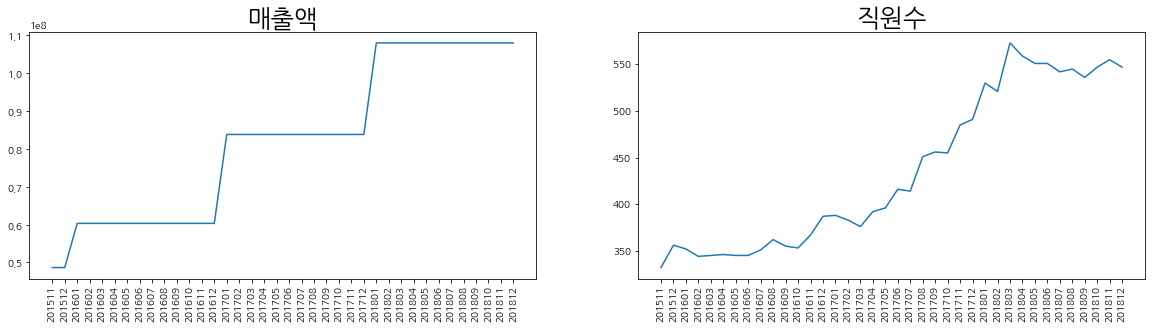

In [14]:
new_list = [294387, 294337, 294367, 126664, 227414, 403359, 440030, 469677] # 매출액과 직원수가 양의 상관관계를 갖는 회사ID

for x in new_list :
    visualization(df,x)